In [50]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
import graphviz
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [13]:
train_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/train.csv',na_values=-1)
test_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/test.csv',na_values=-1)
sample_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/sample_submission.csv')

In [14]:
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]
#所有calc变量
calc_features=[feat for feat in train_df.columns if 'calc' in feat]

In [15]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


In [16]:
use_features=[x for x in train_df.columns if x not in ['id','target']]

In [17]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=9)

# 1 Base line

In [158]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',gini(y, preds) / gini(y, y),True

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='auc',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    #print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    #print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0：.6f}'.format(gini_normalized_ordinary(y,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='gain')
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [233]:
params={'boosting_type':'gbdt',
        'num_leaves':20,
        'max_depth':6,
        'learning_rate':0.3,
        'n_estimators':38,
        'max_bin':255,
        'objective':'binary',
        'min_split_gain':1,
        'min_child_weight':5,
        'min_child_samples':1,
        'subsample':0.8,
        'subsample_freq':1,
        'colsample_bytree':0.8,
        'reg_alpha':0,
        'reg_lambda':0,
        'random_state':9,
        'n_jobs':4,
        'is_unbalance':True,
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':8,
        'max_depth':3,
        'learning_rate':0.3,
        'max_bin':255,
        'objective':'binary',
        'min_gain_to_split':1,
        'min_sum_hessian_in_leaf':5,
        'min_data_in_leaf':1,
        'bagging_fraction':0.8,
        'bagging_freq':1,
        'feature_fraction':0.8,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':4,
        'is_unbalance':True,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [135]:
lgbc=lgb.LGBMClassifier(**params)

[20]	cv_agg's auc: 0.628457 + 0.00272447
[40]	cv_agg's auc: 0.629094 + 0.00403532
[60]	cv_agg's auc: 0.628182 + 0.00393359
Best Iteration: 38
Model report on trian:
Train AUC:0.6615
Model report on test:
Test AUC:0.6306
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.63      0.77    114704
          1       0.05      0.56      0.10      4339

avg / total       0.94      0.63      0.74    119043

Test confusion matrix:
Confusion matrix, without normalization
[[72473 42231]
 [ 1927  2412]]


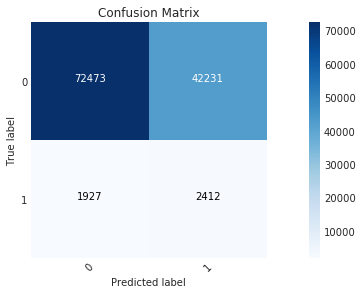

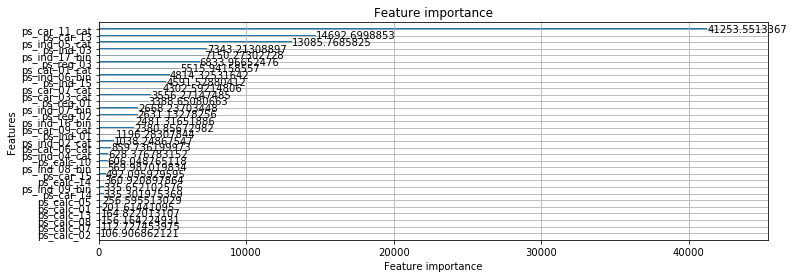

In [136]:
get_lgb_params(lgbc.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,cat_features,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [83]:
#lgb.create_tree_digraph(lgbc)

In [137]:
params['n_estimators']=38

# 2 Tune params

In [127]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

## 2.1 subsample

In [150]:
searchParam={'subsample':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 0.9
Best score: 0.623924422932
           mean_test_score  mean_train_score  std_test_score  std_train_score
subsample                                                                    
0.1               0.582750          0.626622        0.003614         0.001442
0.3               0.608044          0.666197        0.003758         0.001107
0.5               0.618622          0.681435        0.002113         0.000822
0.7               0.620946          0.692656        0.002902         0.000672
0.9               0.623924          0.703990        0.001712         0.000956
1.0               0.623101          0.708420        0.001306         0.000580


In [152]:
searchParam={'subsample':[0.93,0.94,0.95,0.96,0.97]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 0.97
Best score: 0.62436035446
           mean_test_score  mean_train_score  std_test_score  std_train_score
subsample                                                                    
0.93              0.623301          0.705083        0.001692         0.000719
0.94              0.623620          0.705942        0.002505         0.000879
0.95              0.624357          0.705522        0.002013         0.000718
0.96              0.623966          0.706437        0.001829         0.000918
0.97              0.624360          0.707495        0.001531         0.000481


## 2.2 subsample_freq

In [153]:
searchParam={'subsample_freq':[1,2,3,4,5,6,7,8,9]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample_freq : 9
Best score: 0.624862859961
                mean_test_score  mean_train_score  std_test_score  \
subsample_freq                                                      
1                      0.624360          0.707495        0.001531   
2                      0.623342          0.707011        0.001965   
3                      0.622373          0.708170        0.001819   
4                      0.623043          0.708620        0.003030   
5                      0.623033          0.708085        0.003098   
6                      0.624311          0.707190        0.002618   
7                      0.623814          0.707778        0.003000   
8                      0.623689          0.707683        0.004197   
9                      0.624863          0.707701        0.002882   

                std_train_score  
subsample_freq                   
1                      0.000481  
2                      0.001405  
3                      0.001083  
4          

In [154]:
searchParam={'subsample_freq':[9,10,13,15,20,25]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample_freq : 9
Best score: 0.624862859961
                mean_test_score  mean_train_score  std_test_score  \
subsample_freq                                                      
9                      0.624863          0.707701        0.002882   
10                     0.623543          0.708535        0.003470   
13                     0.623964          0.707633        0.003531   
15                     0.622719          0.707979        0.002533   
20                     0.622787          0.707283        0.002655   
25                     0.623462          0.707648        0.002974   

                std_train_score  
subsample_freq                   
9                      0.000902  
10                     0.001344  
13                     0.000546  
15                     0.001434  
20                     0.001190  
25                     0.001486  


## 2.3 colsample_bytree

In [155]:
searchParam={'colsample_bytree':[0.1,0.3,0.5,0.7,0.8,0.9,1.0]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.3
Best score: 0.631277503259
                  mean_test_score  mean_train_score  std_test_score  \
colsample_bytree                                                      
0.1                      0.624900          0.657771        0.002763   
0.3                      0.631278          0.677482        0.001747   
0.5                      0.626293          0.697281        0.002737   
0.7                      0.625584          0.701080        0.002893   
0.8                      0.624863          0.707701        0.002882   
0.9                      0.621290          0.710993        0.003098   
1.0                      0.618995          0.715264        0.002495   

                  std_train_score  
colsample_bytree                   
0.1                      0.000639  
0.3                      0.001443  
0.5                      0.001311  
0.7                      0.001422  
0.8                      0.000902  
0.9                      0.001399  
1.0      

In [157]:
searchParam={'colsample_bytree':np.arange(0.24,0.4,0.02)}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.3
Best score: 0.631277503259
                  mean_test_score  mean_train_score  std_test_score  \
colsample_bytree                                                      
0.24                     0.630350          0.679827        0.002854   
0.26                     0.628828          0.683085        0.001886   
0.28                     0.631180          0.680134        0.002320   
0.30                     0.631278          0.677482        0.001747   
0.32                     0.628964          0.682787        0.002659   
0.34                     0.629898          0.683812        0.001580   
0.36                     0.627522          0.695551        0.003292   
0.38                     0.629099          0.694038        0.003499   
0.40                     0.627820          0.692661        0.003489   

                  std_train_score  
colsample_bytree                   
0.24                     0.000593  
0.26                     0.001186  
0.28       

## 2.4 reg_alpha

In [160]:
searchParam={'reg_alpha':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 10
Best score: 0.632798469654
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000          0.631278          0.677482        0.001747         0.001443
0.00001          0.631278          0.677482        0.001747         0.001443
0.00100          0.631278          0.677482        0.001747         0.001443
0.10000          0.632565          0.677859        0.001570         0.001366
0.50000          0.631724          0.677322        0.002516         0.001755
1.00000          0.631500          0.677602        0.001768         0.001686
3.00000          0.632743          0.677252        0.001555         0.001047
5.00000          0.632689          0.677290        0.002458         0.001491
10.00000         0.632798          0.676330        0.002089         0.001497


In [161]:
searchParam={'reg_alpha':[8,9,10,11,13,15,20]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 13
Best score: 0.634238018283
    mean_test_score  mean_train_score  std_test_score  std_train_score
8          0.631935          0.677113        0.001995         0.001378
9          0.633293          0.676764        0.002692         0.000935
10         0.632798          0.676330        0.002089         0.001497
11         0.632673          0.676711        0.001849         0.001289
13         0.634238          0.676867        0.002047         0.001055
15         0.632968          0.676631        0.001808         0.001006
20         0.633579          0.676571        0.002177         0.000897


In [162]:
searchParam={'reg_alpha':[11.5,12,12.5,13,13.5,14]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 13
Best score: 0.634238018283
      mean_test_score  mean_train_score  std_test_score  std_train_score
11.5         0.632061          0.676672        0.001804         0.000935
12.0         0.633006          0.676450        0.002290         0.000768
12.5         0.633273          0.676601        0.001921         0.001052
13.0         0.634238          0.676867        0.002047         0.001055
13.5         0.633711          0.676977        0.001663         0.001138
14.0         0.633886          0.676589        0.002297         0.001433


## 2.5 reg_lambda

In [163]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.001
Best score: 0.634238036366
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000          0.634238          0.676867        0.002047         0.001055
0.00001          0.634238          0.676867        0.002047         0.001055
0.00100          0.634238          0.676867        0.002047         0.001055
0.10000          0.633969          0.676938        0.002343         0.001150
0.50000          0.633850          0.676792        0.002156         0.001513
1.00000          0.633658          0.676962        0.001747         0.001146
3.00000          0.633429          0.676496        0.002298         0.001228
5.00000          0.632963          0.676264        0.002213         0.000875
10.00000         0.632758          0.676683        0.002694         0.000626


In [164]:
searchParam={'reg_lambda':np.arange(1,10)*1e-3}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.009
Best score: 0.634238272665
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.001         0.634238          0.676867        0.002047         0.001055
0.002         0.634238          0.676866        0.002047         0.001055
0.003         0.634238          0.676866        0.002047         0.001055
0.004         0.634238          0.676866        0.002047         0.001055
0.005         0.634238          0.676866        0.002047         0.001055
0.006         0.634238          0.676866        0.002047         0.001055
0.007         0.634238          0.676866        0.002047         0.001055
0.008         0.634238          0.676866        0.002047         0.001055
0.009         0.634238          0.676866        0.002047         0.001055


## 2.6 min_child_samples

In [171]:
searchParam={'min_child_samples':[1,2,5,10,20,30,50,100]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_samples : 5
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
1           0.634238          0.676866        0.002047         0.001055
2           0.634238          0.676866        0.002047         0.001055
5           0.634286          0.676859        0.002134         0.001064
10          0.633938          0.676871        0.002404         0.001082
20          0.634112          0.676849        0.002433         0.001172
30          0.633639          0.676719        0.001724         0.001288
50          0.633944          0.677029        0.001638         0.001690
100         0.633487          0.676505        0.001754         0.001532


In [172]:
searchParam={'min_child_samples':[3,4,5,6,7]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_samples : 3
Best score: 0.63428579984
   mean_test_score  mean_train_score  std_test_score  std_train_score
3         0.634286          0.676859        0.002134         0.001064
4         0.634286          0.676859        0.002134         0.001064
5         0.634286          0.676859        0.002134         0.001064
6         0.634286          0.676859        0.002134         0.001064
7         0.634286          0.676859        0.002134         0.001064


## 2.7 min_child_weight

In [173]:
searchParam={'min_child_weight':[1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 1e-05
Best score: 0.63428579984
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00001         0.634286          0.676859        0.002134         0.001064
0.00100         0.634286          0.676859        0.002134         0.001064
0.10000         0.634286          0.676859        0.002134         0.001064
0.50000         0.634286          0.676859        0.002134         0.001064
1.00000         0.634286          0.676859        0.002134         0.001064
3.00000         0.634286          0.676859        0.002134         0.001064
5.00000         0.634286          0.676859        0.002134         0.001064


## 2.8 max_bin

In [174]:
searchParam={'max_bin':[31,63,127,255,511]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_bin : 255
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
31          0.632909          0.675524        0.002234         0.001220
63          0.633120          0.675998        0.001408         0.000908
127         0.633413          0.676443        0.002107         0.001359
255         0.634286          0.676859        0.002134         0.001064
511         0.632746          0.676565        0.001914         0.001183


## 2.9 min_split_gain

In [183]:
searchParam={'min_split_gain':[0.5,0.9,1,1.1,2,3]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 1
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.5         0.634007          0.676327        0.002064         0.000875
0.9         0.634016          0.676880        0.002242         0.001080
1.0         0.634286          0.676859        0.002134         0.001064
1.1         0.633735          0.676845        0.002634         0.001043
2.0         0.634004          0.676904        0.001815         0.001361
3.0         0.633310          0.676621        0.001720         0.001495


## 2.10 num_leaves

In [176]:
searchParam={'num_leaves':np.arange(4,10)}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 7
Best score: 0.635499450526
   mean_test_score  mean_train_score  std_test_score  std_train_score
4         0.634265          0.642673        0.001518         0.000440
5         0.634572          0.645314        0.001152         0.000483
6         0.634850          0.648309        0.001404         0.000673
7         0.635499          0.651191        0.001650         0.000421
8         0.635406          0.653547        0.001854         0.000980
9         0.635258          0.656202        0.001742         0.000374


## 2.10 max_depth

In [177]:
searchParam={'max_depth':[2,3,4,5,6]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 4
Best score: 0.635724188011
   mean_test_score  mean_train_score  std_test_score  std_train_score
2         0.634100          0.641946        0.001687         0.000426
3         0.635574          0.650242        0.002159         0.000868
4         0.635724          0.650743        0.002045         0.000634
5         0.635325          0.651277        0.001637         0.000556
6         0.635499          0.651191        0.001650         0.000421


## 2.11 lower learning_rate

[20]	cv_agg's auc: 0.620509 + 0.00403624
[40]	cv_agg's auc: 0.621248 + 0.00439828
[60]	cv_agg's auc: 0.621408 + 0.00411366
[80]	cv_agg's auc: 0.622763 + 0.00368234
[100]	cv_agg's auc: 0.624094 + 0.00366845
[120]	cv_agg's auc: 0.624486 + 0.00365803
[140]	cv_agg's auc: 0.625486 + 0.00356304
[160]	cv_agg's auc: 0.626216 + 0.00355535
[180]	cv_agg's auc: 0.627109 + 0.00360109
[200]	cv_agg's auc: 0.62775 + 0.00365857
[220]	cv_agg's auc: 0.628109 + 0.00365438
[240]	cv_agg's auc: 0.628586 + 0.00363781
[260]	cv_agg's auc: 0.629201 + 0.00363329
[280]	cv_agg's auc: 0.629664 + 0.00372227
[300]	cv_agg's auc: 0.630284 + 0.00368157
[320]	cv_agg's auc: 0.630677 + 0.00370816
[340]	cv_agg's auc: 0.631068 + 0.00374888
[360]	cv_agg's auc: 0.631301 + 0.00378741
[380]	cv_agg's auc: 0.631514 + 0.00379321
[400]	cv_agg's auc: 0.631864 + 0.00380445
[420]	cv_agg's auc: 0.632214 + 0.0038218
[440]	cv_agg's auc: 0.63249 + 0.00379892
[460]	cv_agg's auc: 0.632763 + 0.00382828
[480]	cv_agg's auc: 0.633038 + 0.00384283

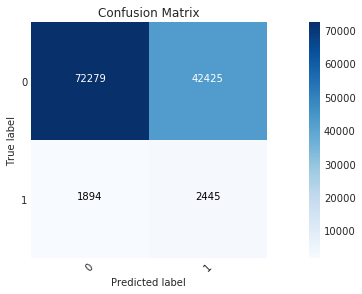

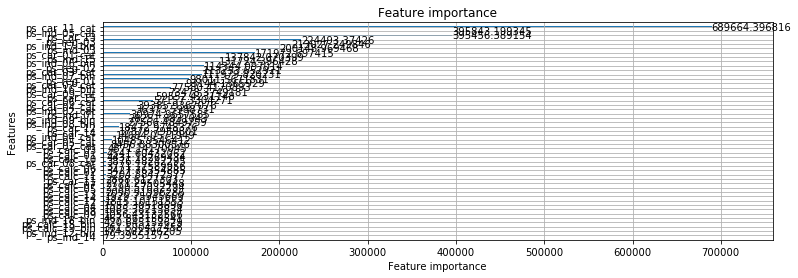

In [243]:
params['learning_rate']=0.01
lgbc=lgb.LGBMClassifier(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,cat_features,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [259]:
params['n_estimators']=1333

# 3 Final model

In [260]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.3,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': 4,
 'min_child_samples': 3,
 'min_child_weight': 1e-05,
 'min_split_gain': 1,
 'n_estimators': 1333,
 'n_jobs': 4,
 'num_leaves': 7,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 13,
 'reg_lambda': 0.009,
 'subsample': 0.97,
 'subsample_freq': 9}

In [261]:
lgbc_opt=lgb.LGBMClassifier(**params)

In [264]:
lgbc_opt.fit(X,y,feature_name=list(X.columns),categorical_feature=cat_features)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.3, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=4, min_child_samples=3,
        min_child_weight=1e-05, min_split_gain=1, n_estimators=1333,
        n_jobs=4, num_leaves=7, objective='binary', random_state=9,
        reg_alpha=13, reg_lambda=0.009, silent=True, subsample=0.97,
        subsample_for_bin=50000, subsample_freq=9)

In [265]:
pred_prob=lgbc_opt.predict_proba(X_predict)[:,1]

In [266]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [267]:
predict_result.head()

,id,target
0,0,0.448932
1,1,0.448197
2,2,0.417098
3,3,0.314295
4,4,0.505310


In [268]:
predict_result.to_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/20171030_12lgbm.csv',index=False)